<a href="https://colab.research.google.com/github/KunalDorik/Tamizan-Skills-Internship-ML-AI-PROJECT-3/blob/main/Project_3_Loan_Eligibility_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving test_Y3wMUE5_7gLdaTN.csv to test_Y3wMUE5_7gLdaTN.csv
Saving train_u6lujuX_CVtuZ9i.csv to train_u6lujuX_CVtuZ9i.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
train = pd.read_csv('train_u6lujuX_CVtuZ9i.csv')
test = pd.read_csv('test_Y3wMUE5_7gLdaTN.csv')

In [ ]:
# Combine train and test for consistent preprocessing
train['is_train'] = 1
test['is_train'] = 0
test['Loan_Status'] = np.nan
data = pd.concat([train, test], sort=False)

# Impute categorical columns with mode, numerical with mean
cat_cols = data.select_dtypes(include='object').columns
num_cols = data.select_dtypes(include=['int64', 'float64']).columns

for col in cat_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)
for col in num_cols:
    data[col].fillna(data[col].mean(), inplace=True)


<ipython-input-6-3224309410>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)
<ipython-input-6-3224309410>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [ ]:
le = LabelEncoder()
for col in cat_cols:
    data[col] = le.fit_transform(data[col])

In [ ]:
train = data[data['is_train'] == 1].drop(['is_train'], axis=1)
test = data[data['is_train'] == 0].drop(['is_train', 'Loan_Status'], axis=1)


In [ ]:
X = train.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = train['Loan_Status']  # Already encoded (0/1)
X_test_final = test.drop(['Loan_ID'], axis=1)

# Split train/validation for evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)
y_pred_proba_lr = lr.predict_proba(X_val)[:,1]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
y_pred_proba_rf = rf.predict_proba(X_val)[:,1]


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.42      0.55        43
           1       0.75      0.95      0.84        80

    accuracy                           0.76       123
   macro avg       0.79      0.68      0.70       123
weighted avg       0.78      0.76      0.74       123



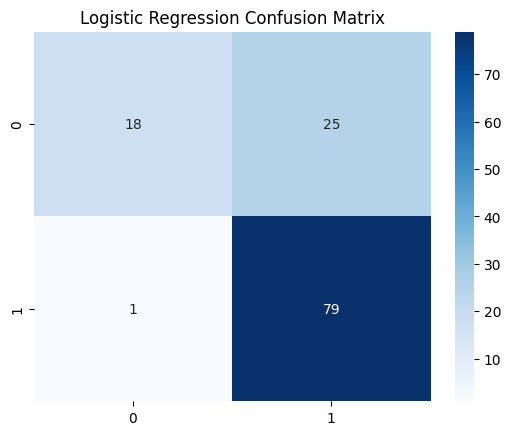

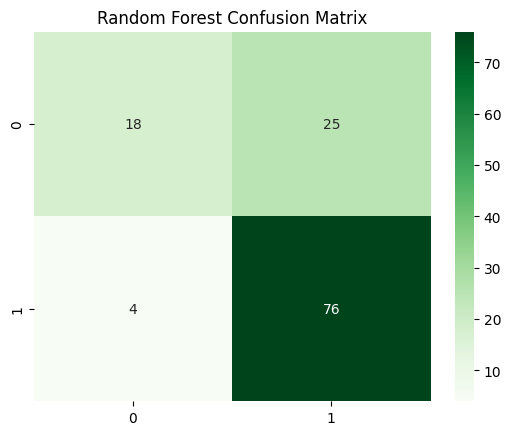

In [ ]:
print("Logistic Regression Classification Report:")
print(classification_report(y_val, y_pred_lr))
print("Random Forest Classification Report:")
print(classification_report(y_val, y_pred_rf))

cm_lr = confusion_matrix(y_val, y_pred_lr)
cm_rf = confusion_matrix(y_val, y_pred_rf)

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Random Forest Confusion Matrix')
plt.show()


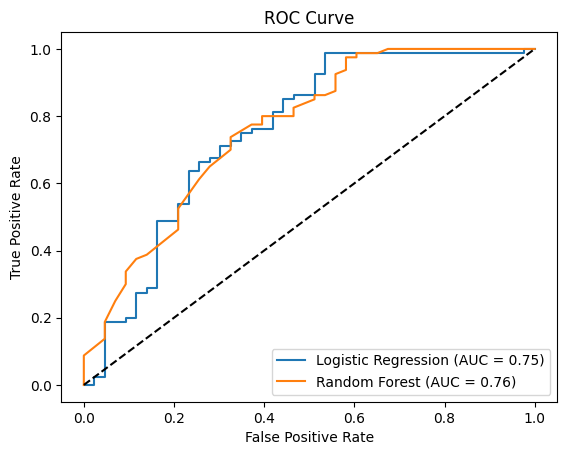

In [ ]:
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_proba_rf)

plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = %.2f)' % roc_auc_score(y_val, y_pred_proba_lr))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %.2f)' % roc_auc_score(y_val, y_pred_proba_rf))
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [ ]:
test_predictions = rf.predict(X_test_final)  # Use Random Forest (or Logistic Regression as desired)
submission = pd.DataFrame({
    'Loan_ID': test['Loan_ID'],
    'Loan_Status': test_predictions
})
# Convert back to original encoding if needed (e.g., 1->'Y', 0->'N')
submission['Loan_Status'] = submission['Loan_Status'].map({1: 'Y', 0: 'N'})
submission.to_csv('loan_predictions.csv', index=False)
print("Predictions saved to loan_predictions.csv")


Predictions saved to loan_predictions.csv


In [ ]:
files.download('loan_predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>